### Table of Contents

1. [Setup and Data Loading](#setup-and-data-loading)  

2. [Demographic Structure and Public Spending Analysis](#demographic-structure-and-public-spending-analysis)  
    &nbsp;&nbsp;&nbsp;&nbsp;• [Age Distribution (Gilang)](#age-distribution)  
    &nbsp;&nbsp;&nbsp;&nbsp;• [Health Expenditure vs Dependency Ratio (Fauziah)](#health-expenditure-vs-dependency-ratio)  
    &nbsp;&nbsp;&nbsp;&nbsp;• [Education Expenditure vs Dependency Ratio (Nomin)](#education-expenditure-vs-dependency-ratio)  
    &nbsp;&nbsp;&nbsp;&nbsp;• [Regression Analysis (Fauziah & Nomin)](#regression)  

3. [Expenditure Projection Analysis (Gilang)](#Health-and-Education-Expenditure-Projections-(to-2050))  

4. [Health–Education Efficiency Index (HEE) Analysis (Patchara)](#healtheducation-efficiency-index-hee-analysis)


## Setup and Data Loading

In [7]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import seaborn as sns

In [8]:
#Import function for cleaning, merged, and import data from cleaning_data.py and Import_and_Cleaning.py
sys.path.append('../src/Import_and_Cleaning')
from import_and_merge_data import load_and_merge_all_data

df_main = load_and_merge_all_data()
df_main.to_csv('../data/interim/merged_data.csv', index=False)
df_main.head()



,Country,ISO3,Year,Health_Expenditure,Education_Expenditure,Dependency_Ratio,Dependency_Ratio_Old,Dependency_Ratio_Young,Life_Expectancy,Mortality_Rate,average_schooling,learning_scores,GDP_percapita,trade_gdp,gov_consumption_gdp,Population,income_level,Region
0,Argentina,ARG,2000,8.220011,4.58031,60.8399424011737,15.536780754278,45.3031616468956,73.910,16.7,8.802,NaN,7637.014892,22.622445,13.784191,37213984,Upper middle income,Latin America & Caribbean
1,Argentina,ARG,2001,8.371799,4.83374,60.442088771688,15.6034995940423,44.8385891776457,74.154,16.2,8.870,NaN,7141.475077,21.852255,14.156274,37624825,Upper middle income,Latin America & Caribbean
2,Argentina,ARG,2002,7.393312,4.01734,60.0100181534326,15.6661577646685,44.3438603887641,74.312,15.8,9.395,NaN,2569.699635,41.752724,12.235247,38029349,Upper middle income,Latin America & Caribbean
3,Argentina,ARG,2003,6.894516,3.53505,59.5157720560259,15.7037442216745,43.8120278343514,74.307,15.4,9.920,NaN,3320.477751,40.644748,11.438057,38424282,Upper middle income,Latin America & Caribbean
4,Argentina,ARG,2004,7.228683,3.48652,58.9908808603745,15.7354699936422,43.2554108667324,74.871,14.9,10.010,NaN,4242.020991,40.692646,11.114636,38815916,Upper middle income,Latin America & Caribbean


This is our main dataset, consists of 17 columns:
1. Country
2. ISO Code
3. Health Expenditure (% of GDP)
4. Education Expenditure (% of GDP)
5. Dependency Ratio (% of working-age population)
6. Dependency Ratio Old (older than 64, % of working-age population)
7. Dependency Ratio Young (younger than 15, % of working-age population)
8. Life Expectancy (years)
9. Mortality Rate (per1000 live births)
10. Average Year Schooling (years)
11. Learning Outcomes (score)
12. GDP per capita (USD)
13. Trade to GDP
14. Government consumption to GDP
15. Population
16. Income Level Category
17. Region

## Descriptive Statistics

**Table 1. Descriptive Statistics of Key Fiscal, Demographic, and Outcome Variables**

In [9]:
# Overall summary of all numeric columns
df_main.describe().T.round(2)


,count,mean,std,min,25%,50%,75%,max
Year,2754.0,2025.00,14.72,2000.00,2012.00,2025.00,2038.00,2050.00
Health_Expenditure,1241.0,6.36,2.72,1.77,4.37,5.85,8.12,18.81
Education_Expenditure,1030.0,4.16,1.32,0.35,3.28,4.12,5.06,7.66
Life_Expectancy,1242.0,73.29,6.51,47.14,69.70,73.98,78.04,84.56
Mortality_Rate,1242.0,18.72,18.13,1.80,5.40,13.50,23.88,97.10
average_schooling,1237.0,9.34,2.83,1.48,7.39,9.92,11.46,14.30
learning_scores,200.0,454.63,62.18,309.02,408.73,444.00,517.00,581.00
GDP_percapita,1242.0,13566.71,17502.79,109.59,1969.26,5069.88,18239.74,106194.76
trade_gdp,1185.0,81.60,57.10,19.56,47.36,64.48,100.36,437.33
gov_consumption_gdp,1177.0,14.90,4.35,2.36,11.44,14.87,18.38,39.84


This table provides a summary of key variables across all countries and years in the dataset. On average, countries spend 6.36% of GDP on health and 4.16% on education, with substantial variation between them (e.g., health spending ranges from 1.77% to 18.81%).

Life expectancy averages 73.3 years, while child mortality shows wide disparities, with some countries reaching as high as 97 per 1,000 births. Schooling outcomes also vary, with average years of schooling at 9.3 and average standardized learning scores around 454 (sample limited to 200 observations).

GDP per capita ranges from just $110 to over $106,000, highlighting the diverse economic landscape. Trade openness is high on average (81.6% of GDP), with some small economies reaching extreme levels (437%). Government consumption averages 14.9% of GDP.

**Table 2. Averages of Fiscal, Outcome, and Demographic Indicators by Income Level**

In [10]:
df_main.groupby('income_level')[['Health_Expenditure', 'Education_Expenditure', 'Life_Expectancy', 'Mortality_Rate', 'average_schooling', 'learning_scores', 'GDP_percapita', 'trade_gdp', 'gov_consumption_gdp']].mean().T.round(2)


income_level,High income,Low income,Lower middle income,Upper middle income
Health_Expenditure,8.27,4.13,4.99,5.73
Education_Expenditure,4.49,4.72,3.79,4.04
Life_Expectancy,78.84,59.67,68.34,72.84
Mortality_Rate,5.06,59.77,33.92,16.36
average_schooling,11.81,2.11,7.51,8.82
learning_scores,512.15,355.52,402.54,436.84
GDP_percapita,31628.39,456.41,2043.48,5674.55
trade_gdp,97.53,34.71,74.43,71.57
gov_consumption_gdp,17.52,9.40,12.96,13.90


This table highlights clear disparities across income groups. High-income countries spend the most on both health (8.27%) and education (4.49%) as a share of GDP, and have the best outcomes: life expectancy (78.8 years), lowest child mortality (5.1 per 1,000), and the highest average schooling (11.8 years) and learning scores (512).

In contrast, low-income countries spend less on health (4.13%), and though they slightly outspend on education (4.72%), they show the worst human development outcomes: life expectancy of 59.7 years, mortality rate of 59.8, and average schooling of only 2.1 years. Their GDP per capita is extremely low (≈$456), with limited government consumption (9.4%) and trade openness (34.7%).

Lower- and upper-middle income countries fall in between. Interestingly, lower-middle income countries have higher trade-to-GDP ratios than low-income countries but lower government consumption shares. Upper-middle income countries, while closer to high-income nations in life expectancy and schooling, still lag significantly in per capita income and efficiency of spending.

These patterns underscore the importance of resource availability, but also raise questions about spending efficiency—particularly why similar spending levels in education across groups result in vastly different learning outcomes.

**Table 3. Regional Averages of Fiscal, Outcome, and Development Indicators**

In [11]:
df_main.groupby('Region')[['Health_Expenditure', 'Education_Expenditure', 'Life_Expectancy', 'Mortality_Rate', 'average_schooling', 'learning_scores', 'GDP_percapita', 'trade_gdp', 'gov_consumption_gdp']].mean().T.round(2)


Region,East Asia & Pacific,Europe & Central Asia,Latin America & Caribbean,Middle East & North Africa,North America,South Asia,Sub-Saharan Africa
Health_Expenditure,5.25,7.07,7.14,6.21,12.97,2.77,4.12
Education_Expenditure,3.91,4.45,4.18,4.17,5.42,2.61,3.92
Life_Expectancy,75.00,74.79,74.10,73.26,79.45,66.69,57.02
Mortality_Rate,14.98,11.58,15.95,19.91,5.55,51.03,60.07
average_schooling,9.42,11.29,8.28,7.89,13.31,5.08,4.99
learning_scores,484.55,487.62,418.32,397.95,527.81,363.77,379.66
GDP_percapita,17094.45,17811.42,7248.41,3807.27,47341.93,1175.92,1159.30
trade_gdp,106.94,95.30,54.91,74.31,46.77,35.67,42.71
gov_consumption_gdp,13.94,17.18,13.22,15.16,17.68,8.85,12.37


This table presents regional averages and reveals stark contrasts in public spending, socioeconomic outcomes, and efficiency potential.

North America shows the highest investment in both health (12.97%) and education (5.42%), along with leading outcomes such as life expectancy (79.45 years), low mortality (5.55), and top learning scores (527.8). Europe & Central Asia and East Asia & Pacific also perform relatively well, with decent spending levels and strong average schooling and learning scores.

Latin America & the Caribbean maintains moderate spending levels and outcomes, but lower learning scores (418.3) despite relatively high education investment (4.18% of GDP), pointing to possible inefficiencies.

In contrast, South Asia and Sub-Saharan Africa face substantial challenges. Despite having very low GDP per capita (around $1,100), they also allocate the least to health and education and suffer from low life expectancy, high child mortality, and learning outcomes below 380. These regions may benefit most from improved spending efficiency and structural reforms.

Middle East & North Africa sits between these extremes, with slightly below-average spending but decent life expectancy and moderate learning outcomes.

Notably, trade openness is highest in East Asia & Pacific (106.9%) and Europe & Central Asia (95.3%), while government consumption varies regionally, with the highest shares in North America and Europe, and the lowest in South Asia.



**Table 4. Correlation Matrix of Public Spending, Outcomes, and Economic Indicators**

In [12]:
df_main[['Health_Expenditure', 'Education_Expenditure','Life_Expectancy', 'Mortality_Rate', 'average_schooling', 'learning_scores', 'trade_gdp', 'gov_consumption_gdp', 'GDP_percapita']].corr()


,Health_Expenditure,Education_Expenditure,Life_Expectancy,Mortality_Rate,average_schooling,learning_scores,trade_gdp,gov_consumption_gdp,GDP_percapita
Health_Expenditure,1.000000,0.409638,0.579503,-0.533171,0.612720,0.474519,-0.125129,0.604824,0.600901
Education_Expenditure,0.409638,1.000000,0.300282,-0.356888,0.297761,0.296160,0.003532,0.529338,0.259880
Life_Expectancy,0.579503,0.300282,1.000000,-0.894091,0.662059,0.716214,0.259440,0.467389,0.672955
Mortality_Rate,-0.533171,-0.356888,-0.894091,1.000000,-0.734317,-0.716919,-0.291180,-0.485454,-0.526017
average_schooling,0.612720,0.297761,0.662059,-0.734317,1.000000,0.751288,0.212242,0.501271,0.615894
learning_scores,0.474519,0.296160,0.716214,-0.716919,0.751288,1.000000,0.432582,0.428851,0.736409
trade_gdp,-0.125129,0.003532,0.259440,-0.291180,0.212242,0.432582,1.000000,0.015346,0.279694
gov_consumption_gdp,0.604824,0.529338,0.467389,-0.485454,0.501271,0.428851,0.015346,1.000000,0.402392
GDP_percapita,0.600901,0.259880,0.672955,-0.526017,0.615894,0.736409,0.279694,0.402392,1.000000


Health expenditure is positively correlated with life expectancy (0.58), GDP per capita (0.60), and government consumption (0.60), suggesting that wealthier countries with higher public spending tend to achieve better health outcomes.

Learning scores are strongly related to average schooling (0.75), GDP per capita (0.74), and life expectancy (0.72), emphasizing the compound benefits of both health and education investment.

Government consumption correlates well with education spending (0.53) and health spending (0.60), showing that fiscal expansion is a key driver of social investments.

Mortality rate shows a strong negative correlation with life expectancy (-0.89), as expected, and is also negatively related to schooling (-0.73) and learning scores (-0.72) — confirming that lower health outcomes often go hand-in-hand with weaker educational attainment.

Mortality is also negatively associated with GDP per capita (-0.53) and public spending, reinforcing the developmental gap in lower-income countries.

GDP per capita shows strong positive links with nearly every development indicator: life expectancy (0.67), learning (0.74), schooling (0.62), and public health and education spending, emphasizing that higher income levels enable and often result from better social outcomes.

These patterns support the hypothesis: demographics and economic strength shape the fiscal space and influence the efficiency of public spending. High-income countries tend to convert spending into better human development outcomes more effectively, while low-income countries face structural constraints.

**Figure 1. Distribution of Health and Education Expenditure (% of GDP) by Income Level**

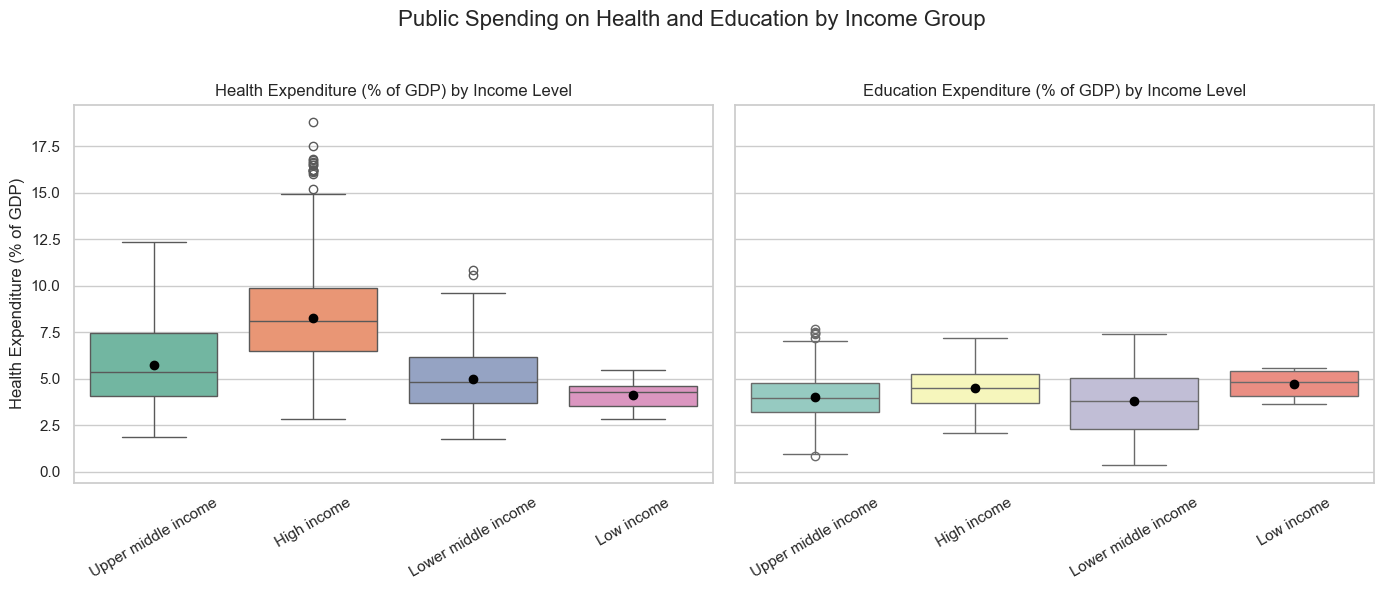

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set a cleaner style
sns.set(style="whitegrid", palette="pastel")

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Boxplot for Health Expenditure ---
sns.boxplot(
    data=df_main,
    x='income_level',
    y='Health_Expenditure',
    hue='income_level',  # Fix for future warning
    palette='Set2',
    ax=axes[0],
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"},
    legend=False
)
axes[0].set_title("Health Expenditure (% of GDP) by Income Level")
axes[0].set_xlabel("")
axes[0].set_ylabel("Health Expenditure (% of GDP)")
axes[0].tick_params(axis='x', rotation=30)

# --- Boxplot for Education Expenditure ---
sns.boxplot(
    data=df_main,
    x='income_level',
    y='Education_Expenditure',
    hue='income_level',
    palette='Set3',
    ax=axes[1],
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"},
    legend=False
)
axes[1].set_title("Education Expenditure (% of GDP) by Income Level")
axes[1].set_xlabel("")
axes[1].set_ylabel("")  # Avoid repeating label
axes[1].tick_params(axis='x', rotation=30)

# Adjust layout
plt.suptitle("Public Spending on Health and Education by Income Group", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


This figure compares the distribution of government spending on health and education across income groups.

High-income countries allocate the highest share to health, with a median above 8%, and a wider range including several outliers exceeding 15–17%.

Upper-middle income countries follow, though with greater spread and lower central tendency.

Lower-middle and low-income countries exhibit both lower medians and narrower spreads, indicating more consistent but constrained health budgets.

In education, the patterns are somewhat different:

Low-income countries appear to prioritize education slightly more in relative terms compared to their health spending, showing a median close to 5%, comparable to upper-middle income groups.

However, high-income countries remain consistently strong in education investment too, with less variability and relatively high means.

The black dots overlaying the boxes represent mean values, offering a fuller picture alongside the median line. Overall, the plots visually reinforce fiscal inequality across income groups and hint at varying fiscal priorities—crucial for understanding spending efficiency in health and education.



**Figure 2. Public Health and Education Spending vs. Life Expectancy by Income Group**

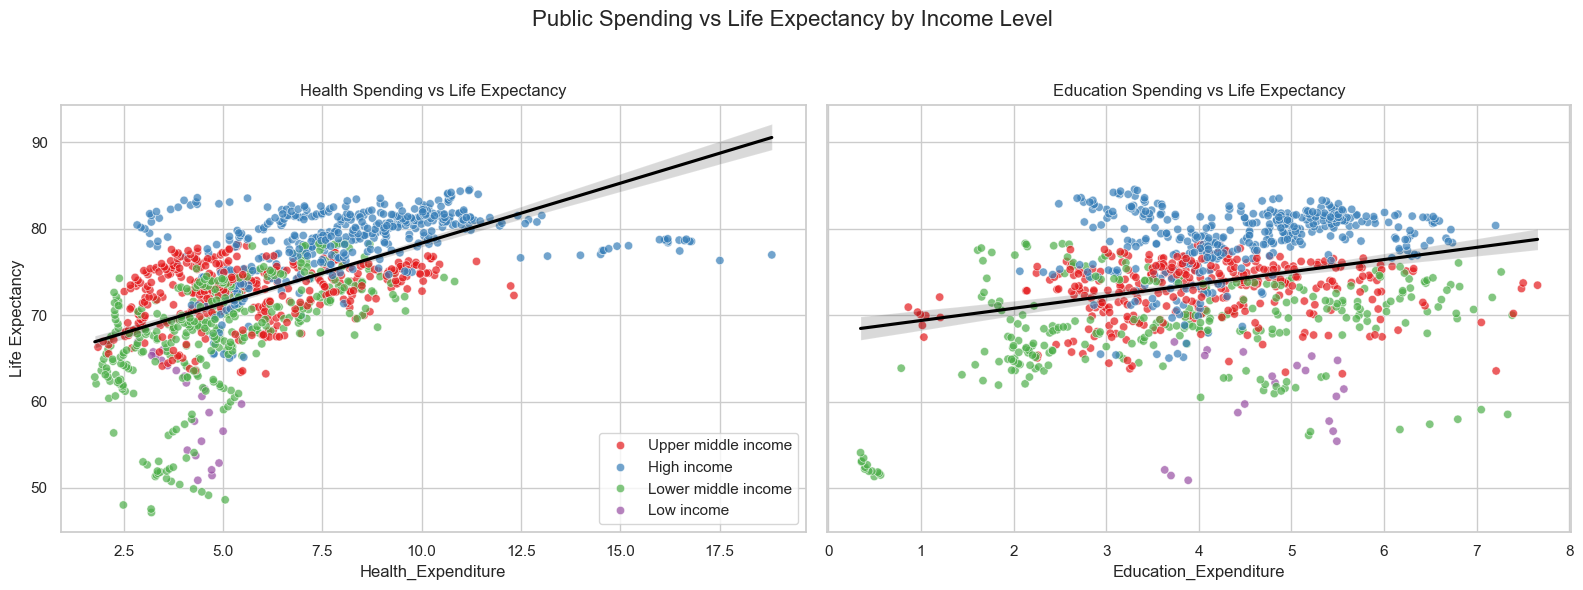

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot 1: Health Expenditure vs Life Expectancy
sns.scatterplot(
    data=df_main,
    x="Health_Expenditure",
    y="Life_Expectancy",
    hue="income_level",
    ax=axes[0],
    palette="Set1",
    alpha=0.7
)
sns.regplot(
    data=df_main,
    x="Health_Expenditure",
    y="Life_Expectancy",
    scatter=False,
    ax=axes[0],
    color="black",
    line_kws={"label": "Linear trend"}
)
axes[0].set_title("Health Spending vs Life Expectancy")
axes[0].legend(loc="lower right")

# Plot 2: Education Expenditure vs Life Expectancy
sns.scatterplot(
    data=df_main,
    x="Education_Expenditure",
    y="Life_Expectancy",
    hue="income_level",
    ax=axes[1],
    palette="Set1",
    alpha=0.7,
    legend=False
)
sns.regplot(
    data=df_main,
    x="Education_Expenditure",
    y="Life_Expectancy",
    scatter=False,
    ax=axes[1],
    color="black",
    line_kws={"label": "Linear trend"}
)
axes[1].set_title("Education Spending vs Life Expectancy")

# Common y-label
axes[0].set_ylabel("Life Expectancy")
axes[1].set_ylabel("")

# Improve layout
plt.suptitle("Public Spending vs Life Expectancy by Income Level", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


This figure compares the relationship between health spending (left) and education spending (right) with life expectancy, across different income levels. A global linear regression line is overlaid in black to indicate the overall trend.

Health Expenditure shows a stronger and steeper correlation with life expectancy. The trendline suggests that increases in health spending are more directly associated with longer life spans.

In contrast, the relationship between education spending and life expectancy is weaker, as seen in the flatter regression slope and wider dispersion. This suggests that education may contribute indirectly or over longer timeframes to health outcomes.

High- and upper-middle income countries are concentrated at the top right of both plots, indicating both higher spending and better outcomes.

Low- and lower-middle income countries cluster toward the bottom left, though some red and green dots (outliers) show relatively good life expectancy even with modest investment—potential candidates for deeper efficiency analysis.

## Demographic Structure and Public Spending

### Old Aging Society

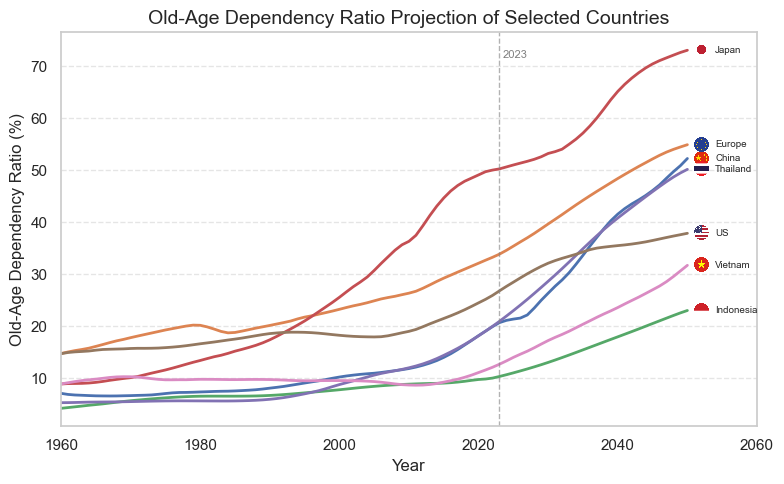

In [ ]:
sys.path.append('../src/Import_and_Cleaning')
from setup_data_delta import get_selected_dependency_data #Call the graph data preparation function
sys.path.append('../src/visualization')
from ratio_lines import plot_dependency_ratio_lines #Call the graph visualization function

df_selected = get_selected_dependency_data()
plot_dependency_ratio_lines(df_selected)


It clearly shows a global trend toward aging societies, especially after the 2000s, where the proportion of elderly individuals relative to the working-age population begins to rise. Japan stands out as the most extreme case—by 2050, its old-age dependency ratio is projected to exceed 70%, meaning there will be more than 70 elderly individuals for every 100 working-age people. This highlights the urgent challenges many nations will face in supporting aging populations sustainable spending.

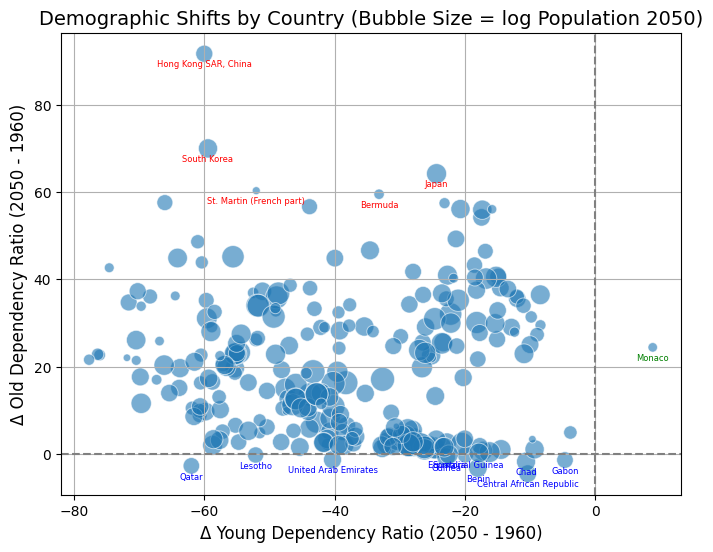

In [3]:
sys.path.append('../src/Import_and_Cleaning')
from setup_data_delta import prepare_change_df #Call the graph data preparation function
sys.path.append('../src/visualization')
from visual_bubble import plot_dependency_bubbles #Call the graph visualization function

change_df = prepare_change_df()
plot_dependency_bubbles(change_df)

This scatter plot highlights global demographic shifts between 1960 and 2050. Most countries are projected to move into the upper-left quadrant—marked by an increase in old-age dependency and a decrease in young-age dependency—indicating growing pressure on the working-age population. Examples include Hong Kong, South Korea, and Japan.

Only a few countries, like Qatar, the UAE, and Gabon, fall in the bottom-left quadrant, where both old and young dependency ratios are declining—suggesting a more favorable demographic structure with a relatively larger working-age population.

In [21]:
sys.path.append('../src/visualization')
from age_dist_visual import set_seaborn_style, create_age_distribution, format_ticks, add_legend, create_image_from_figure, add_padding_to_chart, generate_country_figure, create_grid

population_ratio_female = pd.read_csv("../data/raw/secondary/population_ratio_female.csv", index_col=None)
population_ratio_male = pd.read_csv("../data/raw/secondary/population_ratio_male.csv", index_col=None)

# Set styles
font_family = "PT Mono"
background_color = "#253D5B"
grid_color = "#355882"
text_color = "#EEEEEE"
set_seaborn_style(font_family, background_color, grid_color, text_color)

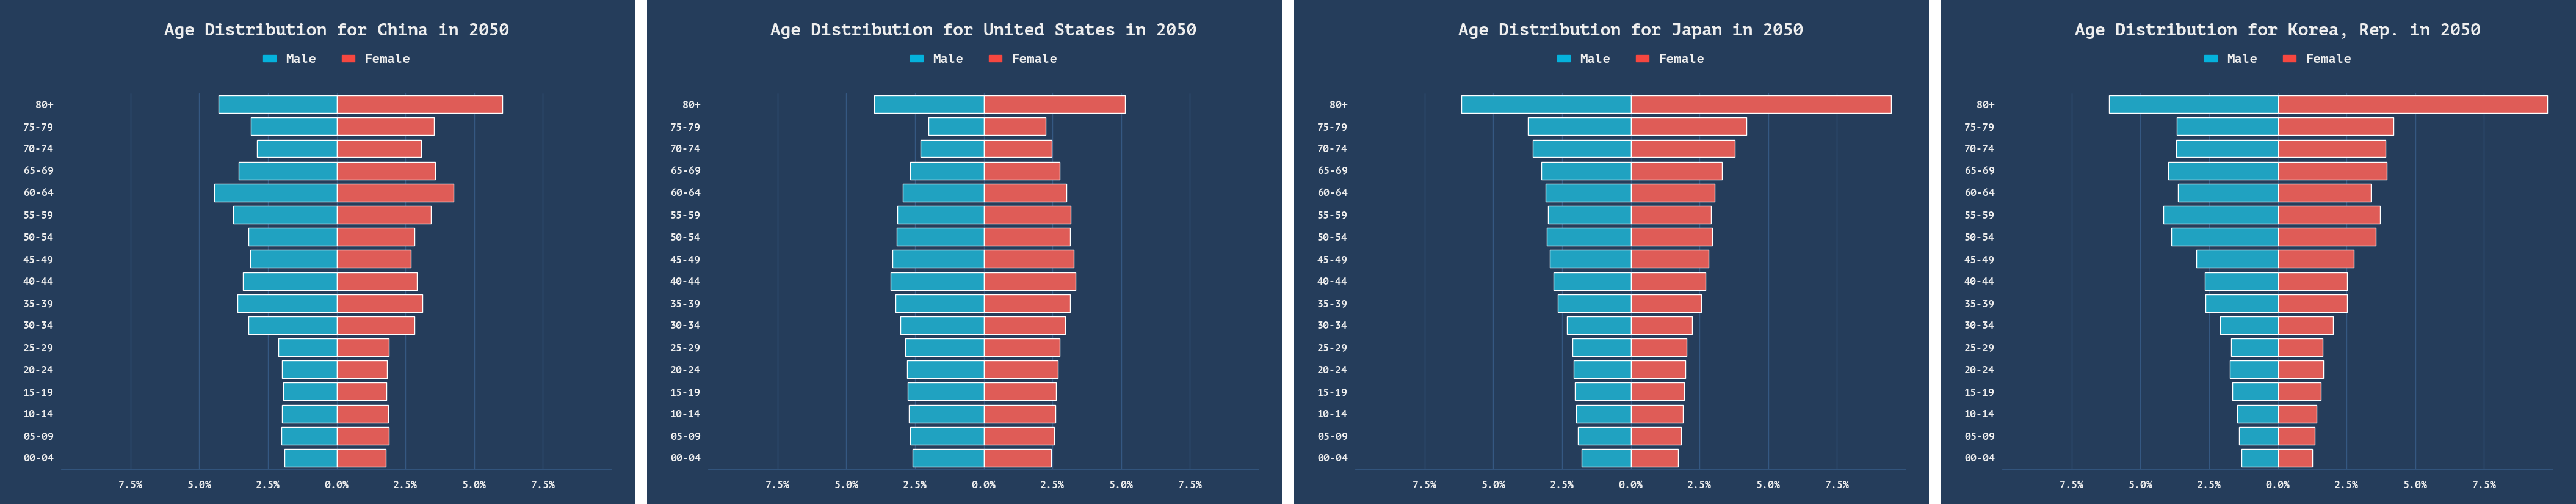

In [22]:
country_codes = ['CHN', 'USA', 'JPN', 'KOR'] 
year = "2050"

# Generate figures
figures = []
for code in country_codes:
    country_name = population_ratio_female[population_ratio_female.country_code == code]["country_name"].iloc[0]
    image = generate_country_figure(
        female_df=population_ratio_female,
        male_df=population_ratio_male,
        country_code=code,
        year=year,
        background_color=background_color
    )
    figures.append(image)

# Display grid
grid = create_grid(figures, pad=20, ncols=4)
grid

These shows the typical shape of aging societies: a bulging top, especially in the 80+ age group. Women dominate these oldest age brackets, reflecting their longer life expectancy. This skewed age distribution is most pronounced in countries like Japan and South Korea, where the base (younger population) is much narrower than the top, signaling major demographic and social challenges ahead.

### Correlation Analysis

Health Expenditure vs Dependency Ratio

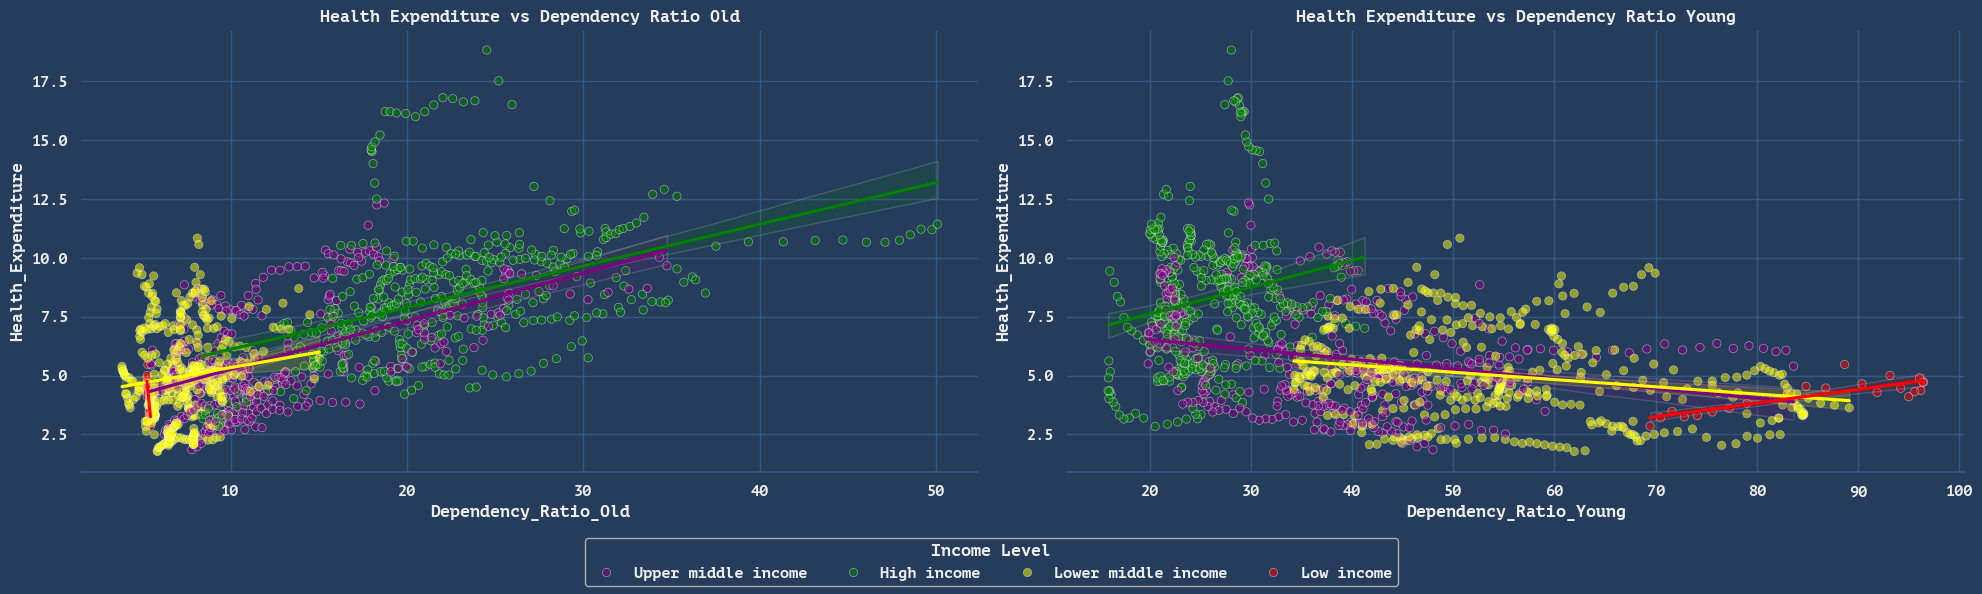

In [23]:
df = pd.read_csv("../data/interim/merged_data.csv")

# Define custom color palette
palette = {
    "High income": "green",
    "Upper middle income": "purple",
    "Lower middle income": "yellow",
    "Low income": "red"
}

# Set up the plot style
#sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Health Expenditure vs Dependency_Ratio_Old
sns.scatterplot(data=df, x="Dependency_Ratio_Old", y="Health_Expenditure", hue="income_level", palette=palette, alpha=0.5, ax=axes[0])
for income, color in palette.items():
    sub_df = df[df["income_level"] == income]
    sns.regplot(data=sub_df, x="Dependency_Ratio_Old", y="Health_Expenditure", scatter=False, color=color, ax=axes[0])
axes[0].set_title("Health Expenditure vs Dependency Ratio Old")

# Plot 2: Health Expenditure vs Dependency_Ratio_Young
sns.scatterplot(data=df, x="Dependency_Ratio_Young", y="Health_Expenditure", hue="income_level", palette=palette, alpha=0.5, ax=axes[1])
for income, color in palette.items():
    sub_df = df[df["income_level"] == income]
    sns.regplot(data=sub_df, x="Dependency_Ratio_Young", y="Health_Expenditure", scatter=False, color=color, ax=axes[1])
axes[1].set_title("Health Expenditure vs Dependency Ratio Young")

# Adjust legend and layout
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Income Level", loc='lower center', ncol=4)
for ax in axes:
    ax.legend_.remove()

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.subplots_adjust(bottom=0.2)
plt.show()

The left graph shows a clear positive correlation between old-age dependency ratio and health expenditure (% of GDP), especially in high-income and upper-middle-income countries. As populations age, healthcare demands tend to rise, and this is reflected in increased spending. Despite some outliers, the trend is consistent across income levels.

In contrast, the right graph—plotting health expenditure against young-age dependency ratio—shows a much weaker and more inconsistent relationship. The trend lines differ by income group, and there’s no clear global pattern. This suggests that the burden of young dependents does not drive health spending as strongly or uniformly as aging populations do.

Education Expenditure vs Dependency Ratio

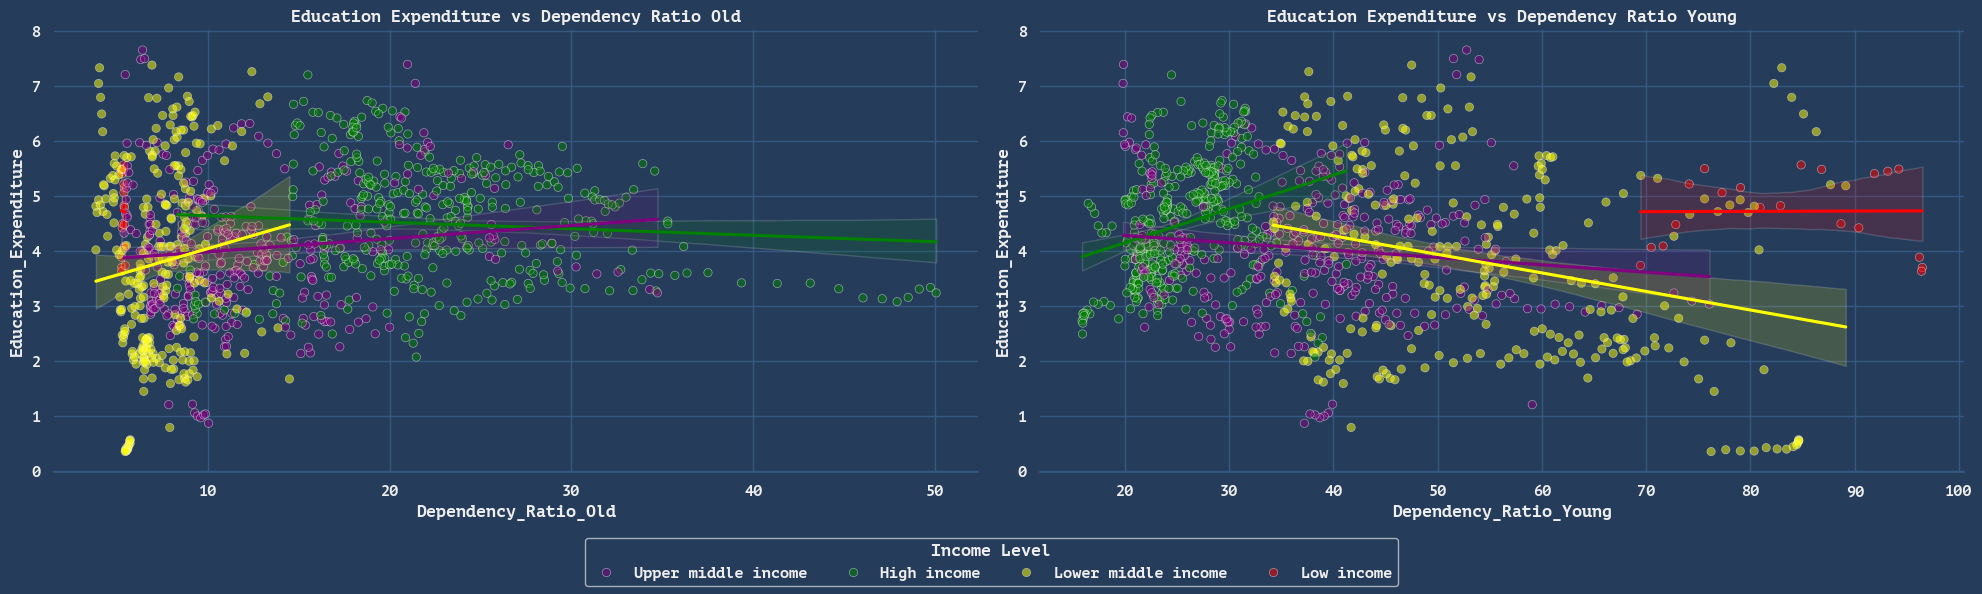

In [24]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Education Expenditure vs Dependency_Ratio_Old
sns.scatterplot(data=df, x="Dependency_Ratio_Old", y="Education_Expenditure", hue="income_level", palette=palette, alpha=0.5, ax=axes[0])
for income, color in palette.items():
    sub_df = df[df["income_level"] == income]
    sns.regplot(data=sub_df, x="Dependency_Ratio_Old", y="Education_Expenditure", scatter=False, color=color, ax=axes[0])
axes[0].set_title("Education Expenditure vs Dependency Ratio Old")

# Plot 2: Education Expenditure vs Dependency_Ratio_Young
sns.scatterplot(data=df, x="Dependency_Ratio_Young", y="Education_Expenditure", hue="income_level", palette=palette, alpha=0.5, ax=axes[1])
for income, color in palette.items():
    sub_df = df[df["income_level"] == income]
    sns.regplot(data=sub_df, x="Dependency_Ratio_Young", y="Education_Expenditure", scatter=False, color=color, ax=axes[1])
axes[1].set_title("Education Expenditure vs Dependency Ratio Young")

# Adjust legend and layout
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Income Level", loc='lower center', ncol=4)
for ax in axes:
    ax.legend_.remove()

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.subplots_adjust(bottom=0.2)
plt.show()

How about education expenditure? In the left graph (old-age dependency), most trend lines are nearly flat, suggesting that increasing elderly populations don’t significantly affect how much countries spend on education. On the right (young-age dependency), there's slightly more variation, but the trends are mixed across income levels — some decline (e.g. lower-middle income), others rise or stay flat. Overall, these plots imply that education spending is likely influenced more by policy priorities and economic capacity than by dependency ratios alone.

### Regression

$$
\text{HealthExp}_{it} = \beta_0 + \beta_1 \cdot \text{DepOld}_{it} + \beta_2 \cdot \text{DepYoung}_{it} + \beta_3 \cdot \text{LnGDPpc}_{it} + \epsilon_{it}
$$

- $\beta_0$: constant term  
- $\beta_1$: effect of aging  
- $\beta_2$: effect of youth burden  
- $\beta_3$: effect of LnGDP per capita  
- $\epsilon_{it}$: error term for country $i$ in year $t$

In [25]:
df = pd.read_csv("../data/interim/merged_data.csv")

# Create log of GDP per capita
df["log_GDP_percapita"] = np.log(df["GDP_percapita"])

# Filter data to years 2000–2022 and drop rows with missing values in key variables
df_model = df[
    (df["Year"] <= 2022) &
    df["Health_Expenditure"].notna() &
    df["Dependency_Ratio_Old"].notna() &
    df["Dependency_Ratio_Young"].notna() &
    df["log_GDP_percapita"].notna()
]

# Run OLS regression
model = smf.ols(
    formula="Health_Expenditure ~ Dependency_Ratio_Old + Dependency_Ratio_Young + log_GDP_percapita",
    data=df_model
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Health_Expenditure   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     392.4
Date:                Sun, 01 Jun 2025   Prob (F-statistic):          4.92e-179
Time:                        09:37:52   Log-Likelihood:                -2586.1
No. Observations:                1241   AIC:                             5180.
Df Residuals:                    1237   BIC:                             5201.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4

The regression results suggest that for every 1 percentage point increase in the old-age dependency ratio, health expenditure (as a % of GDP) **increases by approximately 0.173 percentage points**, holding other variables constant.

Regression - Education Expenditure

In [6]:
df = pd.read_csv("../data/interim/merged_data.csv")

# Create log of GDP per capita
df["log_GDP_percapita"] = np.log(df["GDP_percapita"])

# Filter data to years 2000–2022 and drop rows with missing values in key variables
df_model = df[
    (df["Year"] <= 2022) &
    df["Education_Expenditure"].notna() &
    df["Dependency_Ratio_Old"].notna() &
    df["Dependency_Ratio_Young"].notna() &
    df["log_GDP_percapita"].notna()
]

# Run OLS regression
model = smf.ols(
    formula="Education_Expenditure ~ Dependency_Ratio_Old + Dependency_Ratio_Young + log_GDP_percapita",
    data=df_model
).fit()

print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     Education_Expenditure   R-squared:                       0.068
Model:                               OLS   Adj. R-squared:                  0.065
Method:                    Least Squares   F-statistic:                     25.00
Date:                   Sun, 15 Jun 2025   Prob (F-statistic):           1.29e-15
Time:                           17:28:35   Log-Likelihood:                -1707.5
No. Observations:                   1030   AIC:                             3423.
Df Residuals:                       1026   BIC:                             3443.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

The regression results suggest that for every 1 percentage point increase in the old-age dependency ratio, health expenditure (as a % of GDP) **decreases by approximately 0.0085 percentage points**, holding other variables constant.

In [7]:
df = pd.read_csv("../data/interim/merged_data.csv")

# Create log of GDP per capita
df["log_GDP_percapita"] = np.log(df["GDP_percapita"])

# Filter data to years 2000–2022 and drop rows with missing values in key variables
df_model = df[
    (df["Year"] <= 2022) &
    df["gov_consumption_gdp"].notna() &
    df["Dependency_Ratio_Old"].notna() &
    df["Dependency_Ratio_Young"].notna() &
    df["log_GDP_percapita"].notna()
]

# Run OLS regression
model = smf.ols(
    formula="gov_consumption_gdp ~ Dependency_Ratio_Old + Dependency_Ratio_Young + log_GDP_percapita",
    data=df_model
).fit()

print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     gov_consumption_gdp   R-squared:                       0.392
Model:                             OLS   Adj. R-squared:                  0.391
Method:                  Least Squares   F-statistic:                     252.2
Date:                 Sun, 15 Jun 2025   Prob (F-statistic):          2.85e-126
Time:                         17:30:14   Log-Likelihood:                -3107.8
No. Observations:                 1177   AIC:                             6224.
Df Residuals:                     1173   BIC:                             6244.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

The regression results suggest that for every 1 percentage point increase in the old-age dependency ratio, health expenditure (as a % of GDP) **increases by approximately 0.2593 percentage points**, holding other variables constant.

## Health and Education Expenditure Projections (to 2050)

### GDP per capita projection using log-linear regression

In [29]:
sys.path.append("../src/projection_data")
from projection_data import project_log_gdp

df_projected = project_log_gdp()

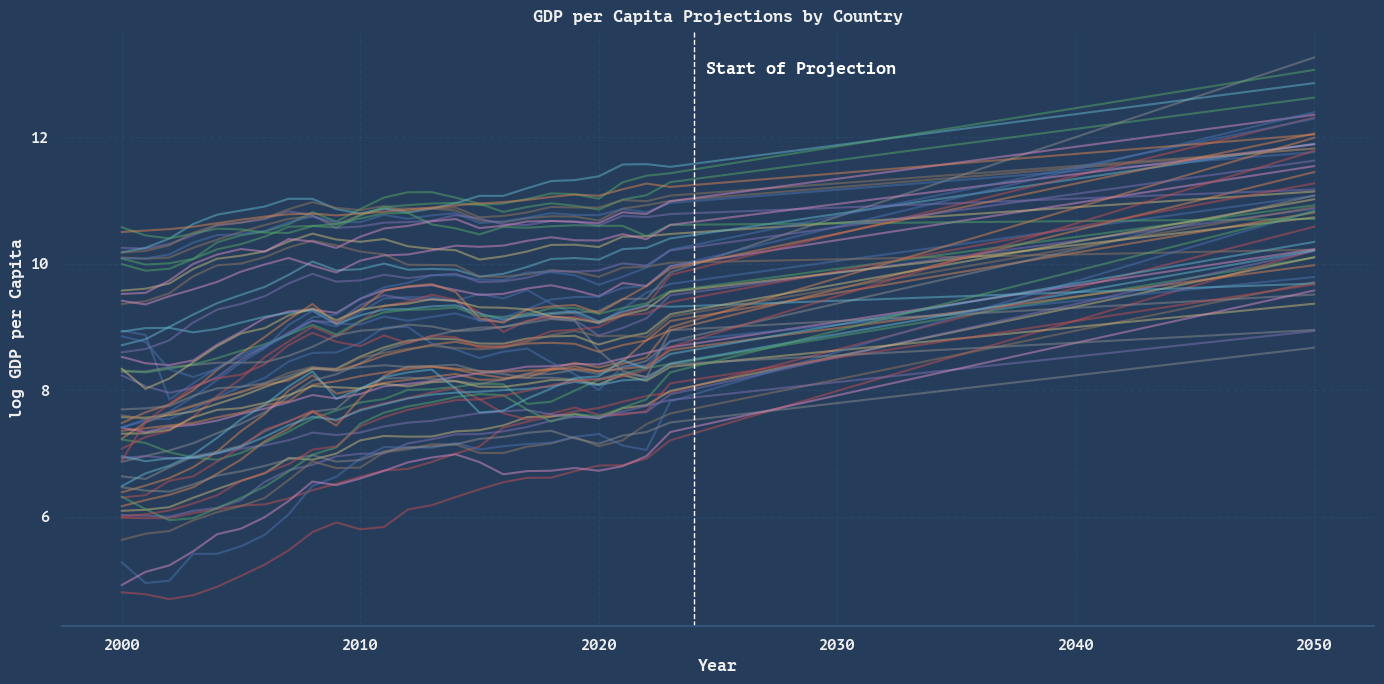

In [30]:
# Plot
plt.figure(figsize=(14, 7))

for iso, group in df_projected.groupby("ISO3"):
    plt.plot(group["Year"], group["log_GDP_percapita"], alpha=0.5)  # light lines

# Add vertical line to mark the start of projection (2024)
plt.axvline(x=2024, color='white', linestyle='--', linewidth=1)
plt.text(2024.5, plt.ylim()[1]*0.95, 'Start of Projection', color='white')

plt.title("GDP per Capita Projections by Country")
plt.xlabel("Year")
plt.ylabel("log GDP per Capita")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Health Expenditure Projection

Using the regression model result in previous part, 

$$
\widehat{\text{HealthExp}}_{it} = -4.8660 + 0.1732 \cdot \text{DepOld}_{it} + 0.0421 \cdot \text{DepYoung}_{it} + 0.8212 \cdot \text{LnGDPpc}_{it}
$$

we predict the value of health expenditure

In [31]:
# List of predictors 
predictors = ["Dependency_Ratio_Old", "Dependency_Ratio_Young", "log_GDP_percapita"]

# Use df_projected and select future years where Health_Expenditure is missing
df_future = df_projected[
    (df_projected["Year"] > 2022) &
    df_projected["Health_Expenditure"].isna() &
    df_projected["Dependency_Ratio_Old"].notna() &
    df_projected["Dependency_Ratio_Young"].notna() &
    df_projected["log_GDP_percapita"].notna()
].copy()

# Predict using the regression model
df_future["Health_Expenditure"] = model.predict(df_future[predictors])

# Update the df_projected with predicted Health_Expenditure
df_projected.update(df_future)

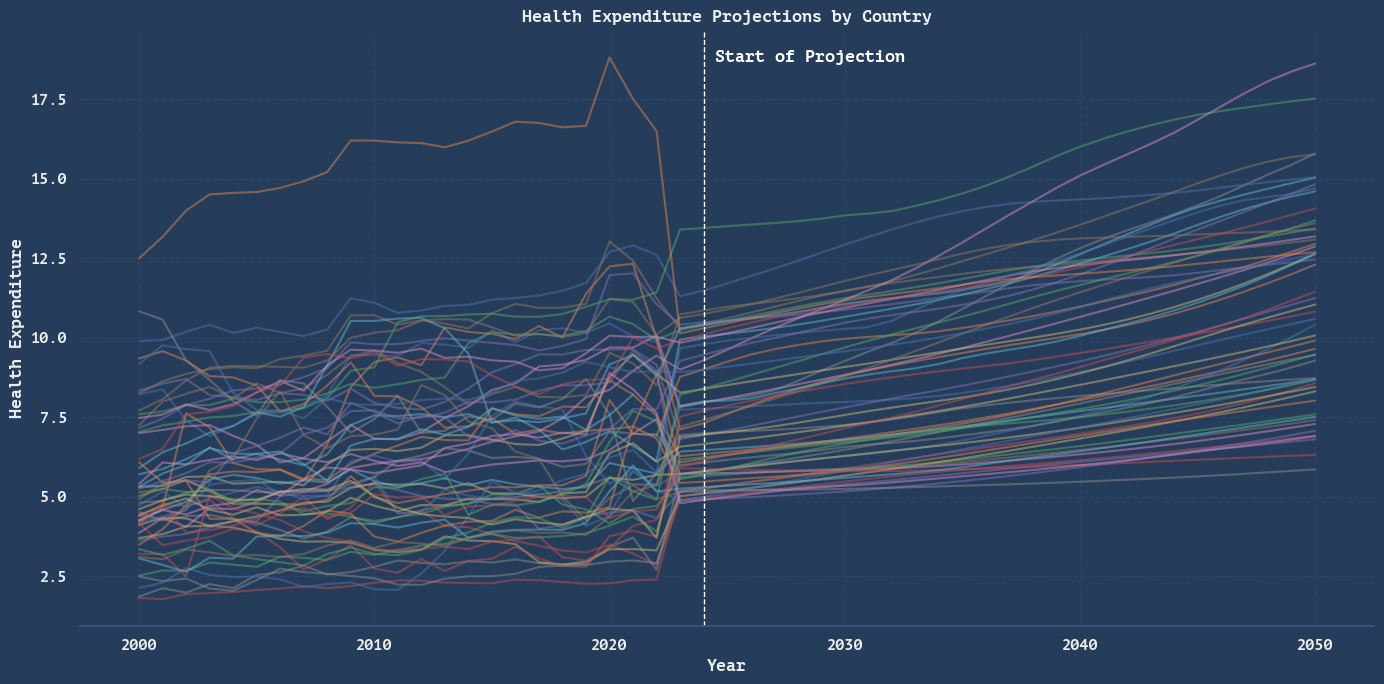

In [32]:
# Plot
plt.figure(figsize=(14, 7))

for iso, group in df_projected.groupby("ISO3"):
    plt.plot(group["Year"], group["Health_Expenditure"], alpha=0.5)  # light lines

# Add vertical line to mark the start of projection (2024)
plt.axvline(x=2024, color='white', linestyle='--', linewidth=1)
plt.text(2024.5, plt.ylim()[1]*0.95, 'Start of Projection', color='white')

plt.title("Health Expenditure Projections by Country")
plt.xlabel("Year")
plt.ylabel("Health Expenditure")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
# Filter for the year 2050
df_2050 = df_projected[df_projected["Year"] == 2050].copy()

# Sort by Health_Expenditure descending and get top 10
top10 = df_2050.sort_values("Health_Expenditure", ascending=False).head(10)

# Display result
print(top10[["Country", "ISO3", "Health_Expenditure"]])

          Country ISO3  Health_Expenditure
2243  South Korea  KOR           18.623577
1070        Japan  JPN           17.516665
407         China  CHN           15.790127
764        Greece  GRC           15.765559
713       Germany  DEU           15.042839
509       Czechia  CZE           15.033606
2192     Slovakia  SVK           14.821719
1988      Romania  ROU           14.696772
1019      Ireland  IRL           14.601134
2090       Serbia  SRB           14.058830


## Health-Education Effeciency Index Analysis